<a href="https://colab.research.google.com/github/aquapathos/BasicAI/blob/master/5CNN/AIChallenge003_%E7%94%BB%E5%83%8F%E3%81%AE%E6%B0%B4%E5%A2%97%E3%81%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 準備
## 0.1 ハードウェアアクセラレータの設定

1. [「AIChallenge001-画像の収集」を済ませておく](https://github.com/aquapathos/BasicAI/blob/master/AIChallenge001_%E7%94%BB%E5%83%8F%E3%81%AE%E5%8F%8E%E9%9B%86.ipynb)

2. [「ランタイム」メニューを開く]()
3. [「ランタイムのタイプを変更」をクリック]()
4. [[「ハードウェアアクセラレータ」で **GPU** を選択し，「保存」]()

<font color='green'>※ Google Colabは無料サービスを維持するため、利用者が多すぎるため GPU が使えない場合があります。その場合は時間がかかりますが、CPUでも実験は可能です。    
※ 同様に、複数セッションが許可されない場合があります。「セッションが多すぎます」と出た場合は他の起動中ランタイムを終了させてください。</font>

# 1. Google Drive をマウント
AIChallenge001 で保存した画像データを使うために Google Drive に接続します。

1. [次のセルを実行する]()
2. [リンクと入力フィールドが表示されるのでリンクをクリック]()
3. [アクセスリクエストを許可するとアクセス用のコードが表示されるのでコピー]()
4. [Enter your authorization code: フィールドに貼り付けて Enter]()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ２．　画像の読み込みと表示
##  2.1 関数定義
001 で使ったプログラムと同じです。　[次のセルを実行]() 



In [ ]:
!pip -q install japanize-matplotlib
import pickle
import os,math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
import pandas as pd
# tensorflow2.x を前提としている。1.x の場合、tensorflow.keras を ただの keras に変える。
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import Input, Activation, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger,TensorBoard

SIZE = 128
# 変数の宣言
DATASIZE = SIZE *  SIZE * 3

# pickle 形式で保存された画像データの読み込み
def loadCategoryImages(fname, folder = "."):
    f = open(folder+"/"+fname,'rb')
    cat = pickle.load(f)
    f.close
    return cat

# 画像データの表示
# start番からnpic枚表示する関数を定義
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showimg(images, start = 0, npic = 48):
    n = npic if len(images) >= start+npic else len(images) - start
    plt.figure(figsize=(8,7.5*(math.ceil(n/8))/6),dpi=150)
    i = 0
    while True:
        if i < n :  
            plt.subplot((n-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[start+i][:,:,::-1])
            plt.title("{}".format(start+i))
            i += 1
        else:
            break

## 2.2 画像データの読み込みと内容確認

先に収集した画像データを読み込み、一部を表示して内容が同じか確認しておきます。　[次のセルを実行]() 

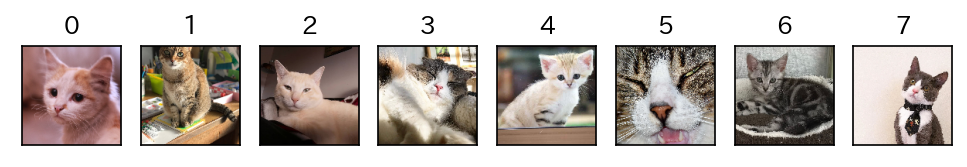

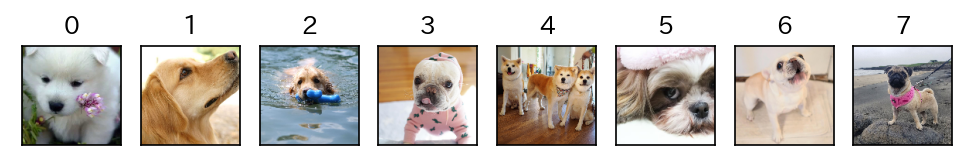

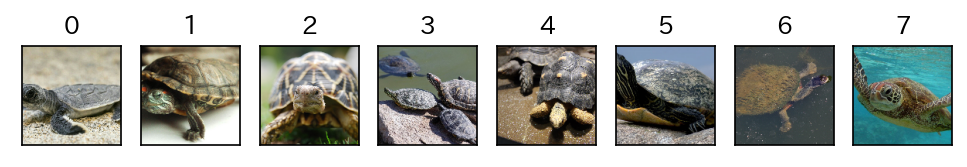

In [ ]:
GFOLDER = "drive/My Drive/LDATA"  # データ保存用のフォルダ名
c0img = loadCategoryImages("ネコ.pkl", folder=GFOLDER)
c1img = loadCategoryImages("イヌ.pkl", folder=GFOLDER)
c2img = loadCategoryImages("カメ.pkl", folder=GFOLDER)
showimg(c0img,0,8)
showimg(c1img,0,8)
showimg(c2img,0,8)

# データの水増し
**[ImageDataGenerator](https://keras.io/ja/preprocessing/image/)** を用いてデータを水増しする。

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import shutil
from glob import glob

def dataInflation1(inimg,num):

    datagen = ImageDataGenerator(
            rotation_range=0, # 画像をランダムに回転する
            width_shift_range=0.2, # ランダムに水平シフト
            height_shift_range=0.2, # ランダムに垂直シフト
            shear_range=5, # 剪断
            zoom_range=0.2, # ランダムにズームする範囲
            horizontal_flip=True, # 水平方向に入力をランダムに反転
            vertical_flip=True, # 垂直方向に入力をランダムに反転
            rescale=1.0 / 255, # 与えられた値をデータに積算する
            )
    
    # 出力先ディレクトリを作成
    tmpdir = "tmp/tmp"
    os.makedirs(tmpdir,exist_ok=True)
    inimg = inimg.reshape((1,) + inimg.shape)  # 次元を４次元に（ImageDataGeneratorの仕様)

    # 種となる画像から num+1 個のバリエーションを生成 
    g = datagen.flow(inimg, batch_size=1, save_to_dir=tmpdir, save_prefix='img', save_format='png')
    for i in range(num+1): # すべて成功すればnum-1個で良いのだが、稀に生成に失敗するので２つ余分に作っておく
        batch = g.next()

    pathes = glob(os.path.join(tmpdir, "*.png"))[:num-1]
    outimgs = [inimg.reshape(inimg.shape[1:])]
    for files in pathes:
        img = image.load_img(files)
        outimgs.append(np.array(img))
    shutil.rmtree(tmpdir)
    return np.array(outimgs)

def dataInflation(X,num):
    Xs = []
    for img in X:
        Xs.extend(dataInflation1(img,num=num))
    return Xs

### 動作確認


ネコの画像データを4倍に水増し

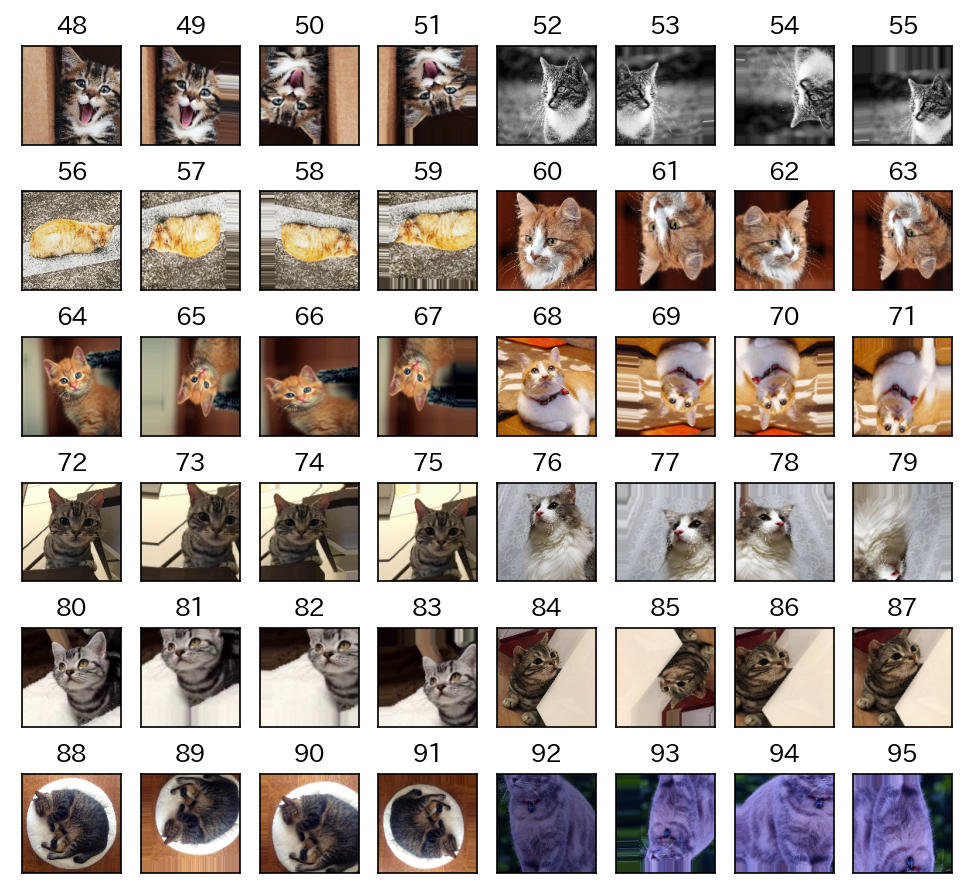

In [ ]:
IMG = dataInflation(c0img,4)
showimg(IMG,48)

# 3. 学習と認識の実験

## 3.1 学習モデル

水増しなしの時と同じなので説明省略

## 3.2 学習データの作成

画像データを訓練用Xtrainとテスト用Xtestに分割し、訓練用はさまざまな変換を施して1枚を24枚に水増しします。

[次のセルを実行]() 

In [ ]:
#  変数の初期化

INFLATION = 24
def make_dataset(catalist):
    # catlist で与えられた画像データのリストから訓練用とテスト用のデータを作成し，
    # Xtrain (訓練用画像), ytrain（訓練例の正解)，Xtrain (テスト用画像), ytrain（テスト画像に対する)，NDATA（1カテゴリ当たりのデータ数）
    # 学習に用いるデータ数を、一番データ数の少ないカテゴリのデータ数に合わせる
    mindata = np.inf # 十分大きな数
    for cat in catalist:
        if len(cat) < mindata:
            mindata = len(cat)
    # ここに到達した時点で、mindata にはもっともデータ数の少ないカテゴリのデータ数が入っている
    NDATA = mindata
    threer = mindata%3
    NDATA = mindata - threer  #  個数を３の倍数となるよう調整

    Xtrain,Xtest = [],[]  # 入力画像のリスト
    ytrain,ytest = [],[]  #  ラベルのリスト
    for cimgs in catalist:
        Xtrain = Xtrain + cimgs[0:int(2*NDATA/3)]
        Xtest = Xtest + cimgs[int(2*NDATA/3):NDATA]
    # 訓練用データXtrainをINFLATION倍に水増し
    Xtrain = dataInflation(Xtrain,INFLATION)
    for label in range(len(catalist)):
        ytrain = ytrain + [label]*int(2*NDATA/3*INFLATION)
        ytest = ytest + [label]*int(NDATA/3)

    return Xtrain,ytrain,Xtest,ytest,NDATA

# ネコ，イヌ，カメの識別

## データの準備

In [ ]:
catnamelist = ['ネコ','イヌ','カメ']
CATALIST=[c0img,c1img,c2img] # c0img:ネコ, c1img:イヌ，c2img:カメ

# 訓練用とテスト用に分割
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

# データ数の確認
ntrain = len(Xtrain)
ntest  = len(Xtest)
print("カテゴリ数 {}   1カテゴリ当たりのデータ数 {}".format(len(CATALIST),NDATA))
print("訓練用 {} テスト用 {}  　データ総数 {}".format(ntrain,ntest,ntrain+ntest))

# 正解データの確認
print(ytest)

カテゴリ数 3   1カテゴリ当たりのデータ数 81
訓練用 3888 テスト用 81  　データ総数 3969
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


↑上のプログラムは水増しに少し時間がかかります。

In [ ]:
# 変数の宣言
CLASSES= len(CATALIST)  #  カテゴリ数　ここでは　３　
DATASIZE = SIZE *  SIZE * 3

# Model 1
model1 = Sequential([
    Dense(CLASSES, activation='softmax', input_shape=(DATASIZE,))
])

model = model1
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら5エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

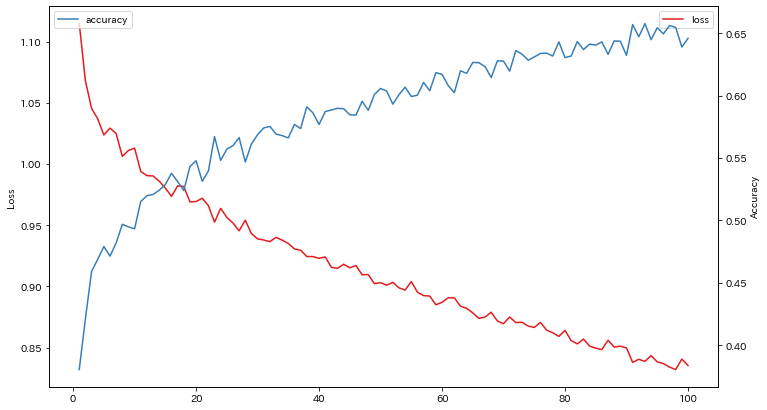

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別実験結果

In [ ]:
# データに対する識別結果
def recognitionResult(model, Xdata, ydata, catnamelist=catnamelist):
    ndata = len(Xdata) # データ数
    predictT = model.predict(Xdata)
    predictT = [np.argmax(n1)  for n1 in predictT]
    NCAT = len(CATALIST) # カテゴリ数
    ct1 = np.zeros((NCAT,NCAT),np.uint16) # 認識結果集計表
    Error = []
    for i in range(ndata):
        ct1[ydata[i],predictT[i]] += 1
        if ydata[i] != predictT[i]:
            Error.append([i,ydata[i],predictT[i]])
    print("誤認識データ（[データ番号, 正解, 認識結果]）\n {0} \n　正解率={1:5.1f}　誤り率＝{2:5.1f} %\n".format(Error,100*(ndata-len(Error))/ndata,100*len(Error)/ndata))
    print("正解カテゴリに対する認識結果と正解率")
    crossT1 = pd.concat([pd.DataFrame(catnamelist,columns=['正解カテゴリ']),pd.DataFrame(ct1,columns=catnamelist)],axis=1)
    crossT1 = pd.concat([crossT1,pd.DataFrame([np.round(1000*crossT1[cat][i]/ndata*NCAT)/10 for i,cat in enumerate(catnamelist)],columns=['正解率'])],axis=1).set_index('正解カテゴリ')

    return Error, crossT1

# 認識間違いの表示
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showEimg(errlist, images):
    last = len(errlist) 
    plt.figure(figsize=(8,7.5*(math.ceil(last/8))/6),dpi=150)
    for i in range(last):
            plt.subplot((last-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[errlist[i][0]][:,:,::-1])
            plt.xlabel("{}→{}".format(catnamelist[errlist[i][1]],
                                catnamelist[errlist[i][2]])) 

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model1, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[5, 0, 1], [6, 0, 1], [12, 0, 1], [13, 0, 1], [21, 0, 1], [24, 0, 2], [26, 0, 2], [27, 0, 2], [28, 0, 2], [29, 0, 1], [31, 0, 1], [32, 0, 1], [35, 0, 2], [36, 0, 2], [37, 0, 2], [39, 0, 2], [41, 0, 2], [45, 0, 2], [52, 0, 2], [73, 0, 2], [74, 0, 2], [75, 0, 2], [80, 0, 2], [81, 0, 2], [84, 0, 2], [86, 0, 1], [87, 0, 1], [88, 0, 2], [90, 0, 2], [91, 0, 1], [92, 0, 2], [96, 0, 2], [104, 0, 2], [110, 0, 2], [113, 0, 2], [115, 0, 2], [118, 0, 2], [124, 0, 2], [125, 0, 2], [126, 0, 2], [127, 0, 1], [128, 0, 2], [130, 0, 1], [132, 0, 2], [134, 0, 2], [136, 0, 2], [137, 0, 1], [139, 0, 2], [141, 0, 2], [142, 0, 2], [144, 0, 1], [145, 0, 1], [146, 0, 2], [147, 0, 2], [148, 0, 1], [151, 0, 1], [152, 0, 1], [153, 0, 2], [154, 0, 1], [155, 0, 2], [156, 0, 1], [157, 0, 1], [158, 0, 2], [160, 0, 1], [162, 0, 1], [163, 0, 2], [164, 0, 2], [165, 0, 2], [167, 0, 2], [168, 0, 1], [169, 0, 1], [170, 0, 2], [171, 0, 1], [172, 0, 1], [173, 0, 1], [174, 0, 1], [175, 0, 2], [176,

,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,606,302,388,46.8
イヌ,99,853,344,65.8
カメ,96,191,1009,77.9


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  if len(TrainError) > 100:
    print("誤認識したデータ(100以上のときは100個まで表示）")
    showEimg(TrainError[:100],Xtrain)
  else:
    print("誤認識したデータ")
    showEimg(TrainError,Xtrain)
else:
  print("誤認識はありません")

## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(model1, Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 2], [1, 0, 1], [2, 0, 1], [3, 0, 1], [5, 0, 1], [7, 0, 2], [8, 0, 2], [9, 0, 1], [10, 0, 1], [12, 0, 2], [13, 0, 1], [14, 0, 1], [15, 0, 2], [17, 0, 1], [18, 0, 2], [19, 0, 1], [20, 0, 2], [21, 0, 2], [23, 0, 2], [24, 0, 2], [25, 0, 2], [26, 0, 1], [28, 1, 0], [29, 1, 2], [30, 1, 0], [31, 1, 0], [33, 1, 2], [37, 1, 2], [39, 1, 2], [41, 1, 2], [42, 1, 2], [43, 1, 0], [44, 1, 2], [47, 1, 2], [49, 1, 0], [50, 1, 2], [51, 1, 2], [52, 1, 2], [54, 2, 1], [56, 2, 0], [59, 2, 0], [62, 2, 1], [65, 2, 0], [66, 2, 1], [67, 2, 0], [72, 2, 1], [78, 2, 0]] 
　正解率= 42.0　誤り率＝ 58.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,5,11,11,18.5
イヌ,5,11,11,40.7
カメ,5,4,18,66.7


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
else:
  print("誤認識はありません")

# model2

In [ ]:
# Model 2

model2 = Sequential([
    Dense(1024,activation='relu',input_shape=(DATASIZE,)),
    Dense(CLASSES, activation='softmax')
])

model = model2
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら2エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

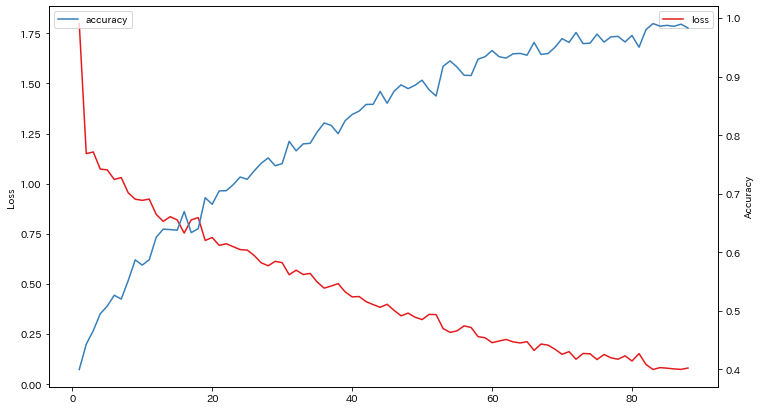

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model2,Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[12, 0, 1], [23, 0, 1], [32, 0, 2], [172, 0, 1], [208, 0, 2], [216, 0, 2], [218, 0, 2], [457, 0, 2], [460, 0, 1], [461, 0, 1], [463, 0, 1], [468, 0, 2], [471, 0, 1], [476, 0, 1], [772, 0, 2], [828, 0, 2], [912, 0, 2], [922, 0, 2], [930, 0, 2], [1009, 0, 1], [1010, 0, 2], [1012, 0, 2], [1014, 0, 2], [1019, 0, 2], [1020, 0, 2], [1022, 0, 2], [1024, 0, 2], [1025, 0, 2], [1026, 0, 1], [1029, 0, 2], [1053, 0, 2], [1205, 0, 2], [1231, 0, 2], [1234, 0, 2], [1297, 1, 2], [1299, 1, 2], [1301, 1, 2], [1332, 1, 2], [1345, 1, 2], [1352, 1, 2], [1353, 1, 2], [1359, 1, 2], [1362, 1, 2], [1429, 1, 2], [1433, 1, 2], [1437, 1, 2], [1439, 1, 2], [1442, 1, 2], [1449, 1, 2], [1454, 1, 2], [1480, 1, 2], [1481, 1, 2], [1485, 1, 2], [1705, 1, 2], [1739, 1, 2], [1810, 1, 2], [1823, 1, 2], [1826, 1, 2], [1827, 1, 2], [1828, 1, 2], [1830, 1, 2], [1840, 1, 2], [1905, 1, 2], [1970, 1, 2], [2233, 1, 2], [2248, 1, 2], [2299, 1, 2], [2306, 1, 2], [2307, 1, 2], [2555, 1, 2]] 
　正解率= 98.2　誤り

,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,1262,10,24,97.4
イヌ,0,1260,36,97.2
カメ,0,0,1296,100.0


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  if len(TrainError) > 100:
    print("誤認識したデータ(100以上のときは100個まで表示）")
    showEimg(TrainError[:100],Xtrain)
  else:
    print("誤認識したデータ")
    showEimg(TrainError,Xtrain)
else:
  print("誤認識はありません")

# テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(model2, Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 1], [2, 0, 2], [3, 0, 2], [4, 0, 2], [5, 0, 1], [6, 0, 2], [7, 0, 2], [8, 0, 2], [9, 0, 1], [10, 0, 1], [12, 0, 2], [13, 0, 1], [14, 0, 1], [15, 0, 2], [17, 0, 1], [18, 0, 2], [19, 0, 2], [20, 0, 1], [21, 0, 2], [22, 0, 2], [23, 0, 1], [24, 0, 2], [26, 0, 1], [28, 1, 2], [30, 1, 0], [32, 1, 2], [33, 1, 2], [39, 1, 2], [41, 1, 2], [42, 1, 0], [43, 1, 0], [44, 1, 2], [45, 1, 0], [46, 1, 2], [47, 1, 0], [49, 1, 0], [52, 1, 2], [59, 2, 0], [60, 2, 1], [62, 2, 1], [63, 2, 0], [66, 2, 1], [67, 2, 0], [69, 2, 1], [72, 2, 1], [79, 2, 1]] 
　正解率= 42.0　誤り率＝ 58.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,3,11,13,11.1
イヌ,6,13,8,48.1
カメ,3,6,18,66.7


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# model3

In [ ]:
# Model ３

model3 = Sequential([
    Conv2D(32, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  # 64 x 64 x 64
    Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  #  32 x 32 x 128
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(CLASSES, activation='softmax')
    ])

model = model3
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

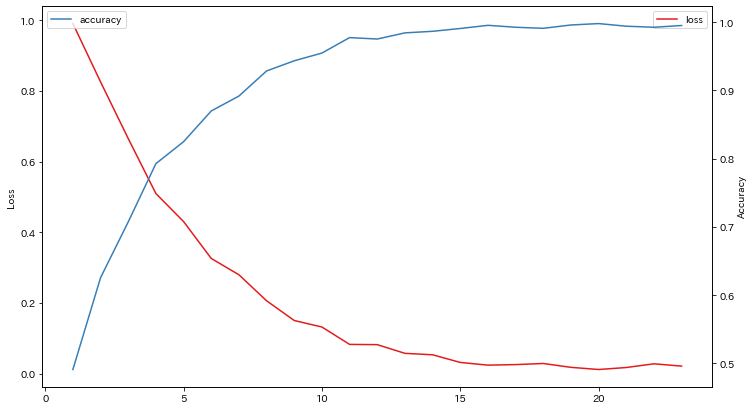

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

# 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model3, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [] 
　正解率=100.0　誤り率＝  0.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,1296,0,0,100.0
イヌ,0,1296,0,100.0
カメ,0,0,1296,100.0


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  if len(TrainError) > 100:
    print("誤認識したデータ(100以上のときは100個まで表示）")
    showEimg(TrainError[:100],Xtrain)
  else:
    print("誤認識したデータ")
    showEimg(TrainError,Xtrain)
else:
  print("誤認識はありません")

誤認識はありません


## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
Xte = (np.array(Xtest).astype('float32'))/255
TestError, crossTable = recognitionResult(model3, Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 2], [2, 0, 1], [3, 0, 1], [5, 0, 1], [8, 0, 2], [9, 0, 2], [10, 0, 1], [12, 0, 2], [13, 0, 2], [14, 0, 2], [16, 0, 2], [18, 0, 1], [19, 0, 1], [20, 0, 1], [21, 0, 2], [22, 0, 2], [25, 0, 1], [26, 0, 1], [31, 1, 0], [33, 1, 2], [34, 1, 0], [37, 1, 2], [39, 1, 2], [42, 1, 0], [43, 1, 0], [45, 1, 0], [46, 1, 2], [48, 1, 2], [49, 1, 0], [50, 1, 0], [51, 1, 2], [60, 2, 0], [62, 2, 0], [64, 2, 1], [65, 2, 0], [72, 2, 0], [74, 2, 1], [79, 2, 0]] 
　正解率= 51.9　誤り率＝ 48.1 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,8,10,9,29.6
イヌ,7,14,6,51.9
カメ,5,2,20,74.1


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
else:
  print("誤認識はありません")

In [ ]:
# MobileNetV2 の出力部分を除いたモデル定義を再利用し、重みは
mnmodel = keras.applications.MobileNetV2(input_shape=(128,128,3),
                                               include_top=False, 
                                               weights='imagenet')
# MobileNetV2 流用部分の構造確認
mnmodel.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
model4 = Sequential([
    mnmodel,
    GlobalAveragePooling2D(),
    Dense(CLASSES, activation='softmax')
])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
catnamelist = ['ネコ','イヌ','カメ']
CATALIST = [c0img,c1img,c2img] # c0img:ネコ，c1img：イヌ, c2img：カメ
CLASSES = len(CATALIST)
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

X = (np.array(Xtrain).astype('float32'))/127.5-1
# X = tf.image.resize(X, (160,160))
y = np.array(ytrain).astype('float32')

Xte = (np.array(Xtest).astype('float32'))/127.5-1
# Xte = tf.image.resize(Xte, (160,160))
yte = np.array(ytest).astype('float32')

model = model4
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

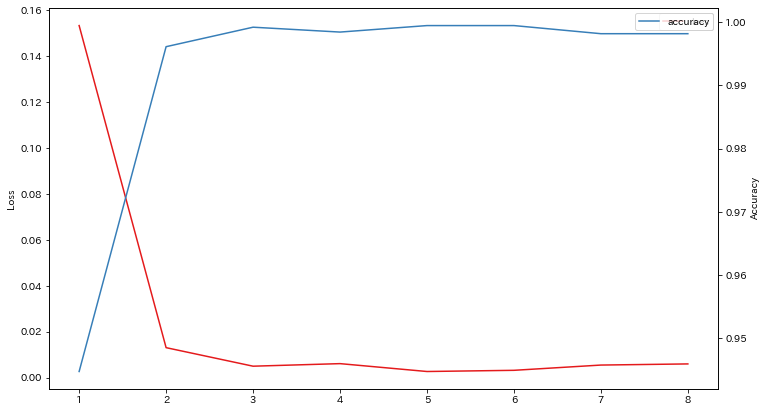

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model4,Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [] 
　正解率=100.0　誤り率＝  0.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,1296,0,0,100.0
イヌ,0,1296,0,100.0
カメ,0,0,1296,100.0


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  if len(TrainError) > 100:
    print("誤認識したデータ(100以上のときは100個まで表示）")
    showEimg(TrainError[:100],Xtrain)
  else:
    print("誤認識したデータ")
    showEimg(TrainError,Xtrain)
else:
  print("誤認識はありません")

誤認識はありません


In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255

TestError, crossTable = recognitionResult(model4, Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[2, 0, 1], [13, 0, 1], [23, 0, 2], [25, 0, 1], [28, 1, 0], [36, 1, 0], [46, 1, 0]] 
　正解率= 91.4　誤り率＝  8.6 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,23,3,1,85.2
イヌ,3,24,0,88.9
カメ,0,0,27,100.0


誤認識したデータ


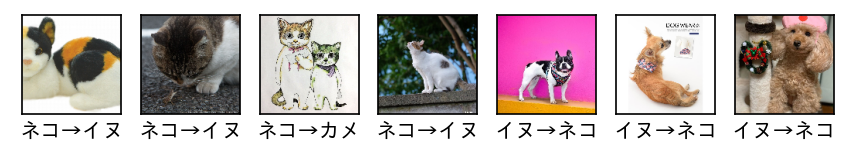

In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

データの水増しは訓練データの不足を補うのが目的であり、効果が上がるべきなのだが、訓練データが少なすぎると、逆にオーバフィッティングを引き起こしてしまうことがあり、訓練データの識別精度は高いのに、テストデータの認識精度が下がってしまうことがある。


# 課題

**自分で選んだカテゴリ（３ないし４）で、各モデルについて水増しなしと水増しありの結果を比較しなさい。**

